## Credit Card User Segmentation

Timothy Divoll - Insight Data Fellow, Boston

#### In this problem, we want to segement credit card users for more targeted marketing strategies. A general approach would be to target three classes: Low-, Medium-, and High-Value customers. To do this, I'll first try an RFM approach to cluster customers by Recency, Frequency, and Monetary Value.

We know that there are 8950 rows of data, one per customer, with data on balances, spending, limits, tenure, cash advances, and tenure.

### Metadata

- CUST_ID : Identification of Credit Card holder (Categorical)
- BALANCE : Balance amount left in their account to make purchases
- BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- PURCHASES : Amount of purchases made from account
- ONEOFF_PURCHASES : Maximum purchase amount done in one-go
- INSTALLMENTS_PURCHASES : Amount of purchase done in installment
- CASH_ADVANCE : Cash in advance given by the user
- PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
- CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
- PURCHASES_TRX : Number of purchase transactions made
- CREDIT_LIMIT : Limit of Credit Card for user
- PAYMENTS : Amount of Payment done by user
- MINIMUM_PAYMENTS : Minimum amount of payments made by user
- PRCFULLPAYMENT : Percent of full payment paid by user
- TENURE : Tenure of credit card service for user

In [101]:
import pandas as pd
CCdf = pd.read_csv("/home/tjd/InsightFiles/cc_info.csv")
CCdf.head(7)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12
6,C10007,627.260806,1.000000,7091.01,6402.63,688.38,0.000000,1.000000,1.000000,1.000000,0.000000,0,64,13500.0,6354.314328,198.065894,1.000000,12


There are not necessarily data columns for recency, frequency, and monetary value, so I will engineer some proxy features to represent each of these important categories. But first, I'll inspect the data to see if it needs any cleaning or if anything is amiss.

In [100]:
CCdf.CUST_ID.nunique() # there are the same number of rows as expected customers

8949

In [36]:
descrip = CCdf[["BALANCE", "TENURE", "PURCHASES_TRX", "CREDIT_LIMIT"]]
descrip.describe()

,BALANCE,TENURE,PURCHASES_TRX,CREDIT_LIMIT
count,8950.000000,8950.000000,8950.000000,8949.000000
mean,1564.474828,11.517318,14.709832,4494.449450
std,2081.531879,1.338331,24.857649,3638.815725
min,0.000000,6.000000,0.000000,50.000000
25%,128.281915,12.000000,1.000000,1600.000000
50%,873.385231,12.000000,7.000000,3000.000000
75%,2054.140036,12.000000,17.000000,6500.000000
max,19043.138560,12.000000,358.000000,30000.000000


It looks like some customers have zero balance and purchases while others have tens of thousands in balance and limit; there should be signal in the data to cluster into segments. Also, the tenure values are assumed to be either months or years.

In [103]:
import numpy as np
CCdf.replace([np.inf, -np.inf], np.nan)
CCdf.isna().sum() # check for NA values

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

I don't plan on initially using the Minimum_Payments feature to cluster so I won't worry about that but will drop the one customer without limit data.

In [104]:
CCdf = CCdf[CCdf["CREDIT_LIMIT"].notna()]


Next, I'll plot the columns to see what outliers and distributions of data look like.

IndexError: index 3 is out of bounds for axis 0 with size 3

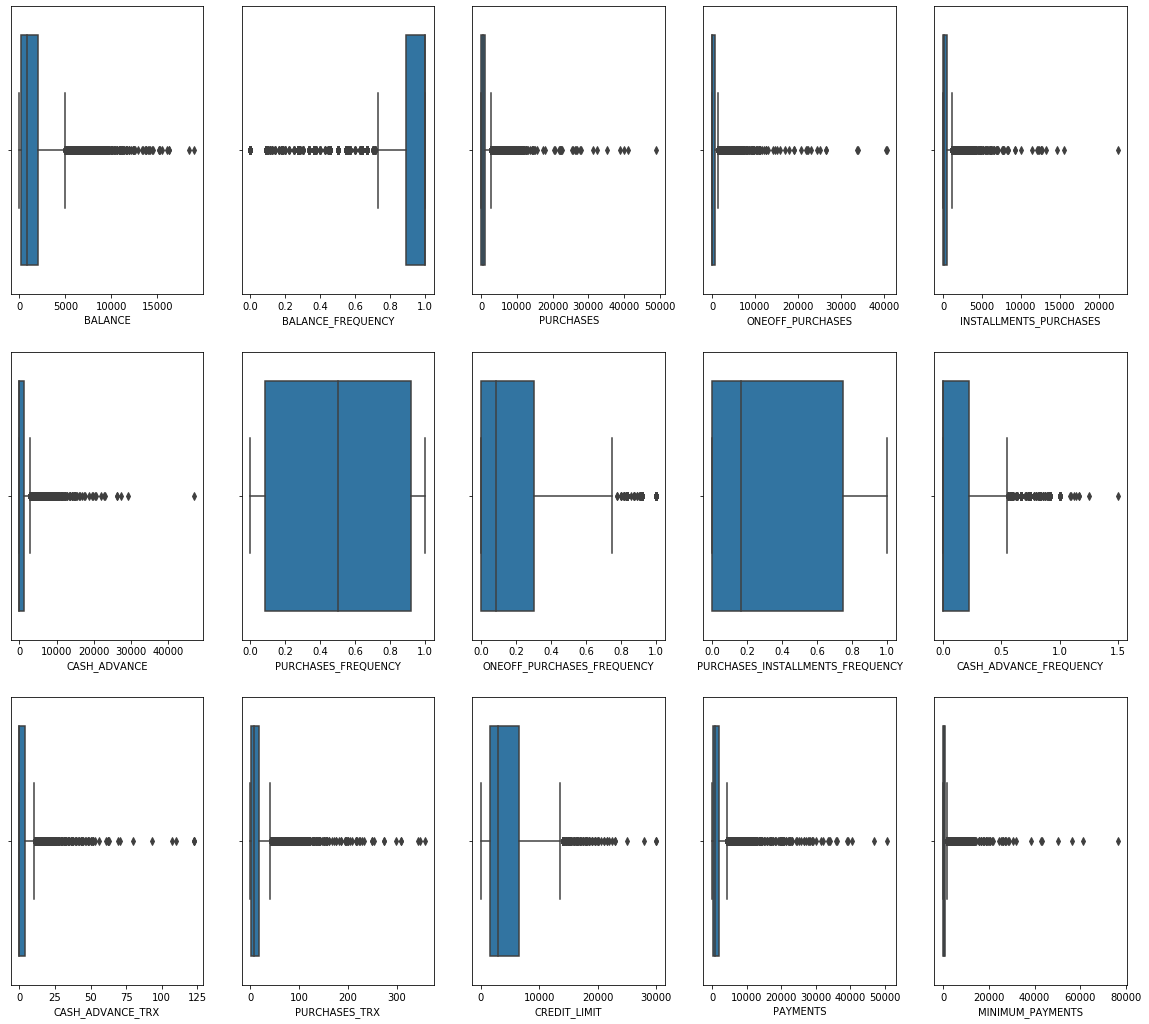

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
boxplots = CCdf.select_dtypes(include='number')
fig, axes = plt.subplots(nrows=3, ncols=5, figsize = (20,18))
for i, column in enumerate(boxplots.columns):
    sns.boxplot(boxplots[column],ax=axes[i//5,i%5])


IndexError: index 3 is out of bounds for axis 0 with size 3

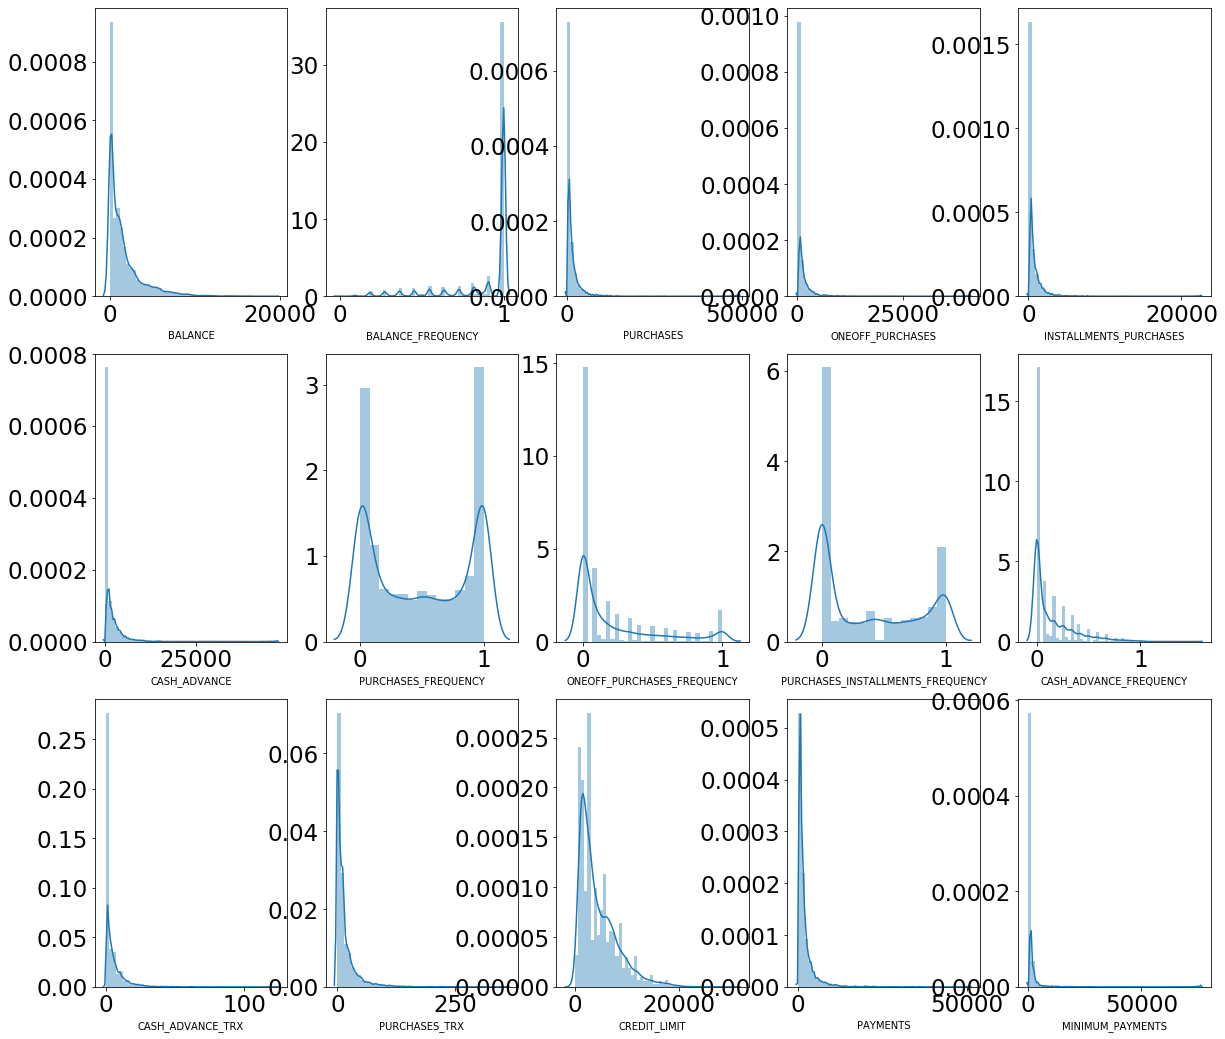

In [111]:
distplots = CCdf.select_dtypes(include='number')
distplots = distplots.dropna()
fig, axes = plt.subplots(nrows=3, ncols=5, figsize = (20,18))
for i, column in enumerate(distplots.columns):
    sns.distplot(distplots[column], ax=axes[i//5,i%5])

It looks like the columns really vary in scale and all are skewed. This will need to be accounted for if I decide to use any type of regression modeling.

## Feature Engineering for RFM clustering
### Proxy for Recency

In [105]:
# First divide the number of purchases by tenure to get a sense of how active each user is, as a proxy of recency. 
# I make the assumption here that higher values are more likely to indicate recent purchases.

CCdf['actproxy'] = CCdf["PURCHASES_TRX"]/CCdf["TENURE"]
CCdf.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,actproxy
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0.166667
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0.000000
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,1.000000
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0.083333
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0.083333


In [106]:
CCdf.actproxy.describe()

count    8949.000000
mean        1.259072
std         2.090575
min         0.000000
25%         0.083333
50%         0.666667
75%         1.500000
max        29.833333
Name: actproxy, dtype: float64

Text(0, 0.5, 'Count of Customers')

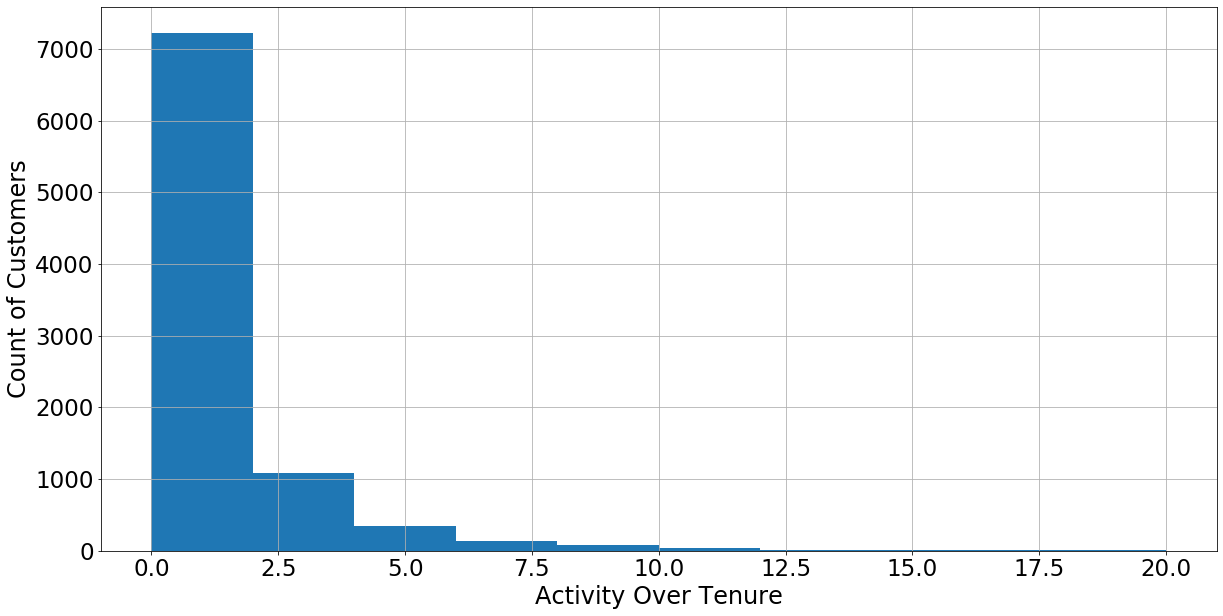

In [107]:
import matplotlib

params = {'axes.titlesize':'28',
          'xtick.labelsize':'23',
          'ytick.labelsize':'23'}
matplotlib.rcParams.update(params)
CCdf['actproxy'].hist(figsize=(20, 10), range=[0, 20])
plt.xlabel('Activity Over Tenure', fontsize=24)
plt.ylabel('Count of Customers', fontsize=24)


Most users have activity scores between zero and two, but some have scores up to 29; this should lend well to segmentation of customers.

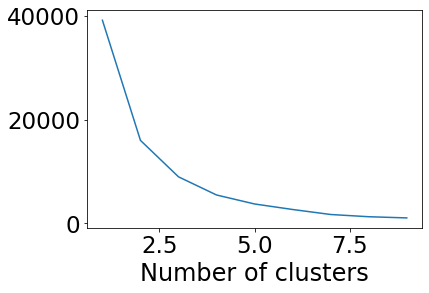

In [110]:
from sklearn.cluster import KMeans
import warnings; warnings.simplefilter('ignore')

sse={}
cc_recency = CCdf[['actproxy']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cc_recency)
    cc_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters", fontsize=24)
plt.show()

In [115]:
# Use this function to order the new clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [118]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(CCdf[['actproxy']])
CCdf['RecencyClusters'] = kmeans.predict(CCdf[['actproxy']])
CCdf = order_cluster('RecencyClusters', 'actproxy', CCdf, True)
CCdf.groupby('RecencyClusters')['actproxy'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyClusters,,,,,,,,
0,6775.0,0.448503,0.450948,0.000000,0.000000,0.333333,0.857143,1.500000
1,1717.0,2.624668,0.852428,1.545455,1.916667,2.416667,3.250000,4.800000
2,408.0,7.026053,1.824942,4.833333,5.500000,6.625000,8.166667,12.000000
3,49.0,17.462121,4.655604,12.250000,13.818182,16.500000,19.083333,29.833333



Great, cluster 3 represents more active users whereas cluster 0 represents rather inactive users.

## Proxy for Frequency

Now I'll make a feature for frquency by summing the frequencies of purchases, one-time, installments, and cash advances to derive a score that indicates how frequently customers uses their card.

In [126]:
CCdf['freqscore'] = CCdf.iloc[:, 7:10].sum(axis=1)         
CCdf.freqscore.describe()

count    8949.000000
mean        1.057364
std         0.914971
min         0.000000
25%         0.166666
50%         0.916667
75%         1.999999
max         3.000000
Name: freqscore, dtype: float64

Text(0, 0.5, 'Count of Customers')

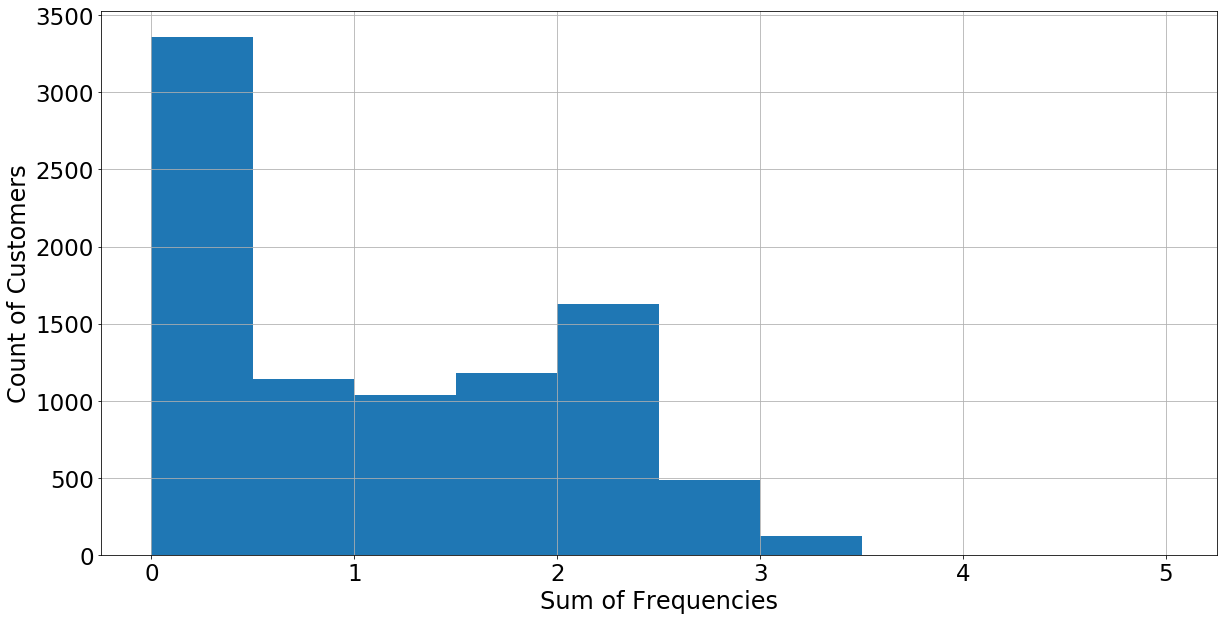

In [131]:
CCdf['freqscore'].hist(figsize=(20, 10), range=[0, 5])
plt.xlabel('Sum of Frequencies', fontsize=24)
plt.ylabel('Count of Customers', fontsize=24)

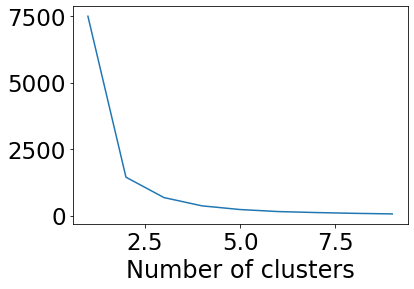

In [144]:
sse={}
cc_freq = CCdf[['freqscore']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cc_freq)
    cc_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters", fontsize=24)
plt.show()

In [133]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(CCdf[['freqscore']])
CCdf['FreqClusters'] = kmeans.predict(CCdf[['freqscore']])
CCdf = order_cluster('FreqClusters', 'freqscore', CCdf, True)
CCdf.groupby('FreqClusters')['freqscore'].describe()

,count,mean,std,min,25%,50%,75%,max
FreqClusters,,,,,,,,
0,3644.0,0.126397,0.166051,0.000000,0.000000,0.000000,0.181818,0.555555
1,1874.0,0.988086,0.251590,0.571428,0.750001,1.000000,1.166667,1.444445
2,2582.0,1.903430,0.201172,1.454545,1.750000,2.000000,2.000000,2.250001
3,849.0,2.633013,0.228423,2.272727,2.416667,2.583333,2.833333,3.000000



Great, cluster 3 represents greater frequency of card use whereas cluster 0 represents infrequent use.

## Proxy for Monetary Value

Credit card companies make money on balances left on cards, and are likely to make money from users that spend more money. Hence, I will make a feature that represents balance on card and total dollar value. Add these makes sense becasue some customers will pay interest ona balance they carry, but not make new purchases and others will spend a lot of money, but never carry a balance.

In [138]:
CCdf['cardbalance'] = CCdf['CREDIT_LIMIT'] - CCdf['BALANCE'] # First calculate the balance held on card
CCdf['revenue'] = CCdf['cardbalance'] + CCdf['PURCHASES']    # Make revenue proxy
CCdf.revenue.describe()

count     8949.000000
mean      3933.118794
std       4246.164860
min       -745.497557
25%       1107.535558
50%       2666.830678
75%       5512.858039
max      59992.049990
Name: revenue, dtype: float64

Text(0, 0.5, 'Count of Customers')

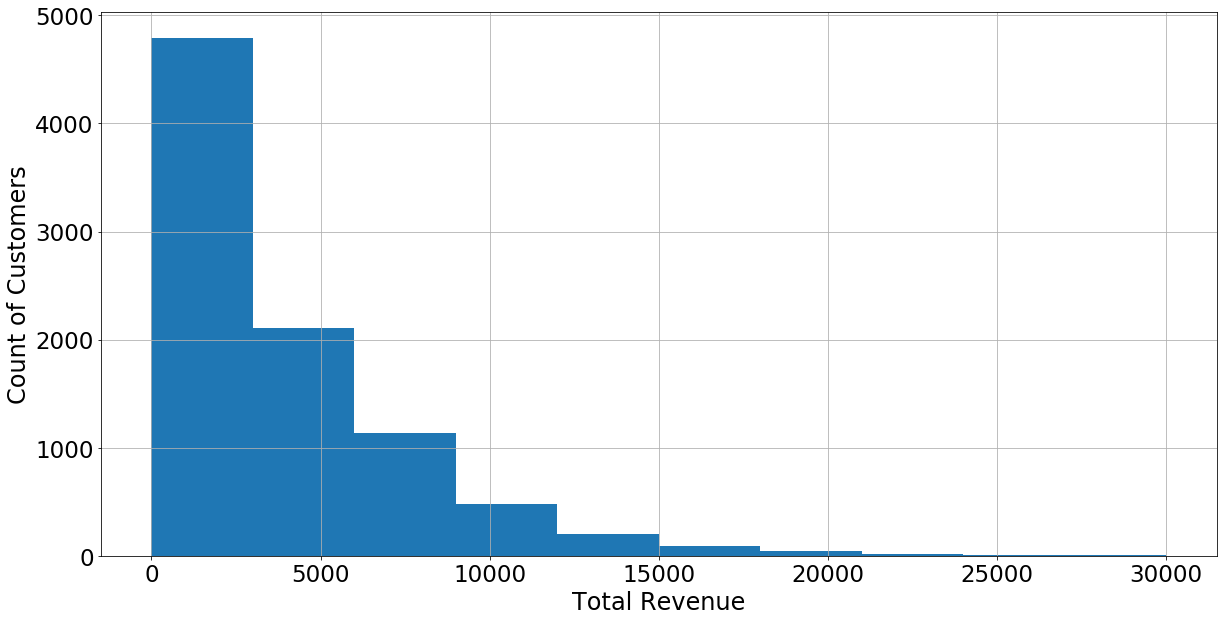

In [142]:
CCdf['revenue'].hist(figsize=(20, 10), range=[0, 30000])
plt.xlabel('Total Revenue', fontsize=24)
plt.ylabel('Count of Customers', fontsize=24)

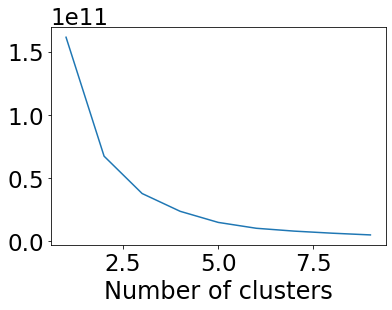

In [145]:
sse={}
cc_revenue= CCdf[['revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(cc_revenue)
    cc_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters", fontsize=24)
plt.show()

In [147]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(CCdf[['revenue']])
CCdf['RevenueClusters'] = kmeans.predict(CCdf[['revenue']])
CCdf = order_cluster('RevenueClusters', 'revenue', CCdf, True)
CCdf.groupby('RevenueClusters')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueClusters,,,,,,,,
0,5579.0,1552.341268,1075.471788,-745.497557,602.819753,1393.573650,2427.242176,3831.709001
1,2634.0,6111.431214,1595.305985,3835.858142,4693.396215,5927.925794,7341.163814,9625.217999
2,701.0,13132.961321,3197.849102,9635.833053,10707.382861,12072.333175,14808.870175,23953.150132
3,35.0,35235.784194,9813.273060,24796.809970,27347.320592,33160.393777,39583.753501,59992.049990


Perfect, cluster 3 represents greater greater total revenue, as a representation of card balance held and total dollar value of purchases; cluster 0 represents lower revenue customers.

## Scoring Clusters for Segmentation
Now that we have clusters for activity, frequency, and revenue, we can add up the cluster indexes per customer to get overall scores that will be useful when grouping customers into Low-, Mid-, and High-Value groups.

In [159]:
CCdf['Score'] = CCdf['RevenueClusters'] + CCdf['FreqClusters'] + CCdf['RecencyClusters']
CCdf.groupby('Score')['actproxy', 'revenue', 'freqscore'].mean()

,actproxy,revenue,freqscore
Score,,,
0,0.078380,1248.641478,0.108675
1,0.467240,3390.173558,0.652222
2,0.944487,3699.923978,1.448438
3,1.754030,4648.380940,1.784703
4,2.605382,6566.198651,2.010691
5,3.435715,8327.254824,2.348034
6,5.543630,10184.897608,2.575461
7,8.003762,14133.100795,2.756906
8,13.684275,24853.297619,2.749591


The table above contains a lot of information about the behavior of different users: clearly some are of High Value and others are of Low Value, which really helps to target strategies and incentives for each type of user. To group the users there seems to be natural splits in the groups that we can use to catgeorize:
- 0 to 2 = Low Value
- 3 to 5 = Mid Value
- 6 to 9 = High Value

In [180]:
CCdf['Segments'] = 'Low-Value'
CCdf.loc[CCdf['Score'] >3, 'Segments'] = 'Mid-Value'
CCdf.loc[CCdf['Score'] >6, 'Segments'] = 'High-Value'

Next we can plot the segments and ivestigate the data with tooltips. When we hover over any of the points, altair returns info on the customer ID, their tenure in months, and their credit limit.

In [181]:
import altair as alt

alt.data_transformers.enable('csv')
alt.Chart(CCdf).mark_circle(size=60).encode(
    x='freqscore',
    y='revenue',
    color='Segments',
    tooltip=['CUST_ID', 'CREDIT_LIMIT', 'TENURE']
).interactive()

alt.Chart(...)

In [182]:
alt.Chart(CCdf).mark_circle(size=60).encode(
    x='freqscore',
    y='actproxy',
    color='Segments',
    tooltip=['CUST_ID', 'CREDIT_LIMIT', 'TENURE']
).interactive()

alt.Chart(...)

In [183]:
alt.Chart(CCdf).mark_circle(size=60).encode(
    x='revenue',
    y='actproxy',
    color='Segments',
    tooltip=['CUST_ID', 'CREDIT_LIMIT', 'TENURE']
).interactive()

alt.Chart(...)

## Visually, the segments have some overlap but the splits seem reasonable as a first approach at targeting different strategies for each segment. Some suggested actions for each are:

### Low -> try to increase frequency of card use
### Mid -> try to balance frequency and retention
### High -> focus on retaining these customers!